In [4]:
import oggm
from oggm import cfg, utils, workflow, tasks, graphics, global_tasks, DEFAULT_BASE_URL
# It will download a small subset of data used for testing and calibration 
# Those data are located in your home directory, in a hidden folder called .oggm
from oggm.sandbox import distribute_2d
from oggm.core import massbalance, flowline
from oggm.core.massbalance import mb_calibration_from_scalar_mb, mb_calibration_from_geodetic_mb, mb_calibration_from_wgms_mb

cfg.initialize()
# It will create a configuration file in your home folder, where you can indicate where you want to store further input data. 
# This configuration file is also located in your home directory under the name .oggm_config.
import folium
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import contextily as ctx
from datetime import datetime
from shapely.geometry import Point, box  # Import box from shapely.geometry

2024-10-15 22:10:08: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-10-15 22:10:08: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-10-15 22:10:08: oggm.cfg: Multiprocessing: using all available processors (N=8)


In [13]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')
# A call to cfg.initialize() will read the default parameter file (or any user-provided file) and
# make them available to all other OGGM tools via the cfg.PARAMS dictionary. 

cfg.PARAMS['melt_f'], cfg.PARAMS['ice_density'], cfg.PARAMS['continue_on_error']
cfg.PARAMS['border'] = 10
# You can try with or without multiprocessing: with two glaciers, OGGM could run on two processors
cfg.PARAMS['use_multiprocessing'] = True

# Local working directory (where OGGM will write its output)
# WORKING_DIR = utils.gettempdir('OGGM_distr4')
#cfg.PATHS['working_dir'] = utils.get_temp_dir('OGGM_distributed', reset=True)
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-calib-mb', reset=True)

2024-10-15 22:19:41: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-10-15 22:19:41: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-10-15 22:19:41: oggm.cfg: Multiprocessing: using all available processors (N=8)
2024-10-15 22:19:41: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-10-15 22:19:41: oggm.cfg: Multiprocessing switched ON after user settings.


In [14]:
# define the glaciers for the run 
# full list of IDs for nevados
rgi_ids = ['RGI60-17.13009', 'RGI60-17.13011', 'RGI60-17.13013', 'RGI60-17.13014', 'RGI60-17.13018', 'RGI60-17.13020', 'RGI60-17.13021', 
           'RGI60-17.13022', 'RGI60-17.13024', 'RGI60-17.13026', 'RGI60-17.13029', 'RGI60-17.13030', 'RGI60-17.13031', 'RGI60-17.13033', 
           'RGI60-17.13034', 'RGI60-17.13044', 'RGI60-17.13045', 'RGI60-17.13047', 'RGI60-17.13049', 'RGI60-17.13050', 'RGI60-17.13051', 
           'RGI60-17.13052', 'RGI60-17.13054', 'RGI60-17.13056', 'RGI60-17.13058'] 

In [15]:
# Let’s use OGGM to download the glacier directories for our selected glaciers:
gdirs = workflow.init_glacier_directories(
    rgi_ids,  # which glaciers?
    prepro_base_url=DEFAULT_BASE_URL,  # where to fetch the data?
    from_prepro_level=4,  # what kind of data? (e.g. can try with 3 for mb data?)
    prepro_border=80  # how big of a map? (zoom level)
)

## add a last number (e.g. [0] or [1] to define which glacier in list of gdirs to run scenarios for)

2024-10-15 22:19:46: oggm.workflow: init_glacier_directories from prepro level 4 on 25 glaciers.
2024-10-15 22:19:46: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 25 glaciers


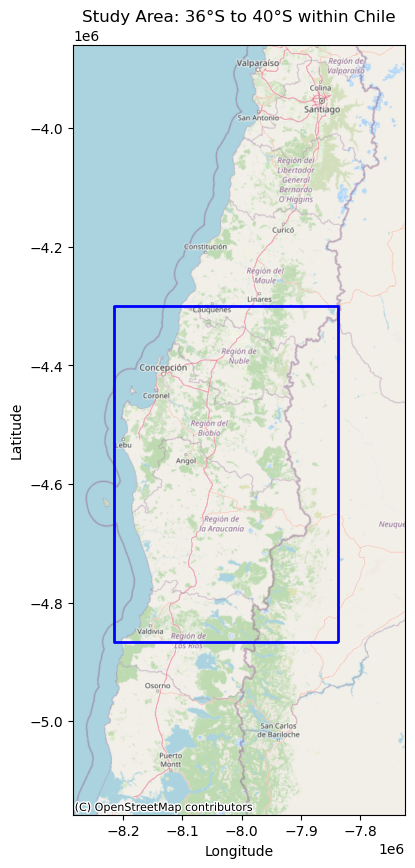

In [8]:
# Define the bounding box for your study area (36°S to 40°S)
min_latitude = -40
max_latitude = -36
min_longitude = -73.8  
max_longitude = -70.4

# Create a GeoDataFrame with the bounding box in EPSG:4326 (WGS84)
bbox = gpd.GeoDataFrame(
    {'geometry': [box(min_longitude, min_latitude, max_longitude, max_latitude)]},
    crs="EPSG:4326"
)

# Reproject the bounding box to EPSG:3857 (Web Mercator) for compatibility with the basemap
bbox_web_mercator = bbox.to_crs(epsg=3857)

# Plot the bounding box on a static map
fig, ax = plt.subplots(figsize=(10, 10))

# Set plot limits to show the entire area of Chile (approximate)
# Adjust the limits to fit the bounds in EPSG:3857
ax.set_xlim(-8284550, -7724420)  # Longitude limits in EPSG:3857
ax.set_ylim(-5157951, -3859190)   # Latitude limits in EPSG:3857

# Add a basemap using OpenStreetMap
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.OpenStreetMap.Mapnik)
# # Add a basemap
# ctx.add_basemap(ax, crs=bbox_web_mercator.crs.to_string(), source=ctx.providers.Esri.WorldImagery)

# Overlay the bounding box for your study area
bbox_web_mercator.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=2)

# Set labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Study Area: 36°S to 40°S within Chile")

# Show the static plot
plt.show()


In [9]:
# Define the bounding box for your study area (36°S to 40°S)
min_latitude = -40
max_latitude = -36
min_longitude = -73.8  
max_longitude = -70.4

# Define the coordinates of the volcanoes in decimal degrees
volcanoes = {
    "Nevado de Longaví": (-71.164378, -36.199316),
    "Nevados de Chillán": (-71.404802, -36.838545),
    "Antuco": (-71.350438, -37.410536),
    "Sierra Velluda": (-71.416628, -37.467096),
    "Copahue": (-71.180380, -37.861159),
    "Callaqui": (-71.451268, -37.924115),
    "Tolhuaca": (-71.646408, -38.310481),
    "Lonquimay": (-71.590441, -38.379551),
    "Sierra Nevada": (-71.586907, -38.589020),
    "Pichi Llaima": (-71.729627, -38.701147),
    "Sollipulli": (-71.523173, -38.975682),
    "Villarrica": (-71.937101, -39.421031),
    "Quetrupillán": (-71.717054, -39.497848),
    "Mocho": (-72.029320, -39.933322)
}

# Create a GeoDataFrame for volcanoes
volcanoes_gdf = gpd.GeoDataFrame(
    {
        "name": list(volcanoes.keys()),
        "geometry": [Point(lon, lat) for lon, lat in volcanoes.values()],
    },
    crs="EPSG:4326"
)

# Create a GeoDataFrame with the bounding box in EPSG:4326 (WGS84)
bbox = gpd.GeoDataFrame(
    {'geometry': [box(min_longitude, min_latitude, max_longitude, max_latitude)]},
    crs="EPSG:4326"
)

# Reproject the bounding box to EPSG:3857 (Web Mercator) for compatibility with the basemap
bbox_web_mercator = bbox.to_crs(epsg=3857)

# Reproject the volcanoes
volcanoes_web_mercator = volcanoes_gdf.to_crs(epsg=3857)

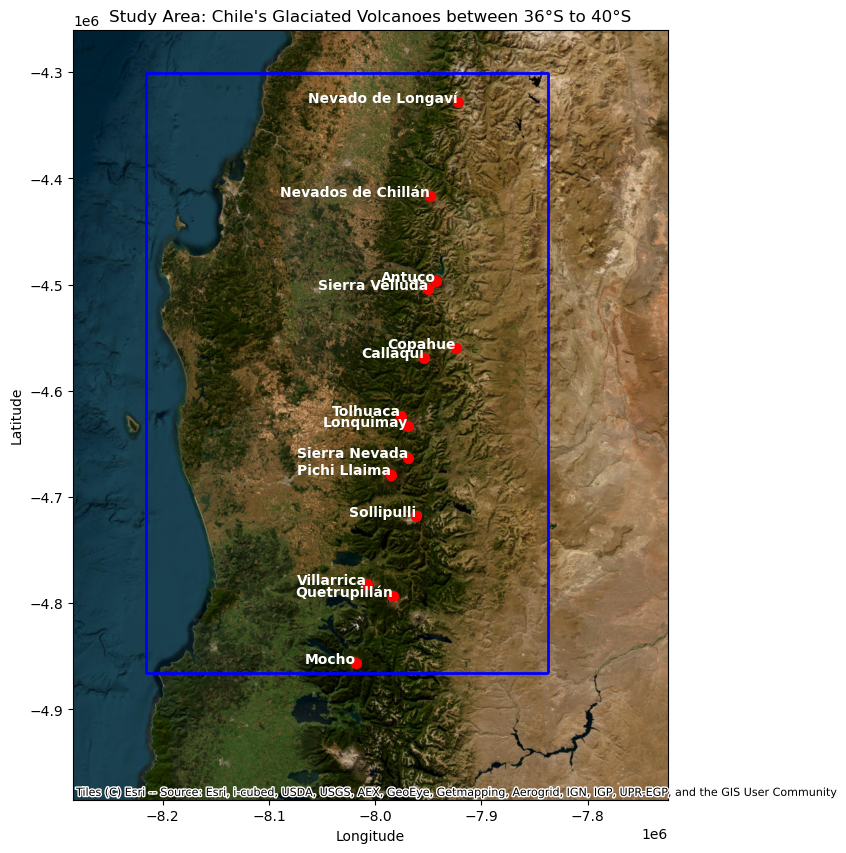

In [10]:
# Plot the bounding box on a static map
fig, ax = plt.subplots(figsize=(10, 10))

# Set plot limits to show the entire area of Chile (approximate)
# Adjust the limits to fit the bounds in EPSG:3857
ax.set_xlim(-8284550, -7724420)  # Longitude limits in EPSG:3857
ax.set_ylim(-4985070, -4259978)   # Latitude limits in EPSG:3857

# Add a basemap
ctx.add_basemap(ax, crs=bbox_web_mercator.crs.to_string(), source=ctx.providers.Esri.WorldImagery)

# Overlay the bounding box for your study area
bbox_web_mercator.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=2)

# Plot the volcanoes
volcanoes_web_mercator.plot(ax=ax, color='red', markersize=50)

# Add labels for volcanoes
for x, y, label in zip(volcanoes_web_mercator.geometry.x, volcanoes_web_mercator.geometry.y, volcanoes_web_mercator['name']):
    ax.text(x, y, label, fontsize=10, color='white', ha='right', fontweight='bold')  # Reduce fontsize if needed

# Set labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Study Area: Chile's Glaciated Volcanoes between 36°S to 40°S")

# Show the static plot
plt.show()